In [34]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.special
import scipy.stats

In [21]:
def poisson_process(rate: float, time_duration: float) -> tuple:
    """
    Generuje proces Poissona na podstawie zadanego współczynnika intensywności i czasu trwania.

    Funkcja generuje liczbę zdarzeń z rozkładu Poissona oraz ich czasy wystąpienia jako skumulowane sumy
    z rozkładu wykładniczego. Tworzony jest także słownik, gdzie kluczami są czasy zdarzeń, a wartościami
    są numery kolejnych zdarzeń.

    Parameters:
        rate (float): Współczynnik intensywności procesu Poissona.
            - Musi być dodatni.
        time_duration (float): Czas trwania symulacji.
            - Musi być dodatni.

    Returns:
        tuple: Krotka zawierająca:
            - num_events (int): Liczba zdarzeń wygenerowanych w czasie symulacji.
            - event_times (np.ndarray): Tablica czasów wystąpienia zdarzeń.
                - Czas od początku symulacji do każdego zdarzenia.
            - N_t (dict): Słownik, gdzie kluczami są czasy zdarzeń, a wartościami są numery zdarzeń.

    Przykład użycia:
        >>> rate = 0.5
        >>> time_duration = 10
        >>> num_events, event_times, N_t = poisson_process(rate, time_duration)
        >>> print(num_events)  # Przykładowy wynik: 5
        >>> print(event_times)  # Przykładowy wynik: [0.52529719 2.83973255 4.71950743 7.49885524 7.9769648 ]
        >>> print(N_t)  # Przykładowy wynik: {0.5252971895590703: 1, 2.8397325522665495: 2, 4.719507434161063: 3, 7.498855235336915: 4, 7.976964802216262: 5}
    """
    # Generowanie liczby zdarzeń z rozkładu Poissona
    num_events = np.random.poisson(rate * time_duration)

    # Generowanie czasów zdarzeń jako skumulowane sumy z rozkładu wykładniczego
    event_times = np.cumsum(np.random.exponential(1 / rate, num_events))

    # Tworzenie słownika N_t za pomocą funkcji zip i dict
    N_t = dict(zip(event_times, range(1, num_events + 1)))

    # Zwracanie liczby zdarzeń, czasów zdarzeń oraz słownika N_t
    return num_events, event_times, N_t


In [22]:
def proces_ruiny(eta: float, u: float, c: float, T: float, lambda_: float) -> int:
    """
    Symuluje proces ruiny kapitału.

    Proces ruiny kapitału opisuje, czy kapitał firmy ubezpieczeniowej ulegnie ruinie w danym okresie czasu,
    biorąc pod uwagę wpływy (składki) i wypływy (roszczenia).

    Parameters:
        eta (float): Średnia wartość roszczenia.
            - Musi być dodatnia.
        u (float): Początkowy kapitał.
            - Musi być dodatni.
        c (float): Średnia wartość składki w jednostce czasu.
            - Musi być dodatnia.
        T (float): Czas trwania symulacji.
            - Musi być dodatni.
        lambda_ (float): Intensywność procesu Poissona (średnia częstość zdarzeń).
            - Musi być dodatnia.

    Returns:
        int: Zwraca 1, jeśli wystąpiła ruina kapitału (kapitał < 0 w dowolnym momencie), w przeciwnym razie 0.

    Przykład użycia:
        >>> eta = 7
        >>> u = 12
        >>> c = 1
        >>> T = 10
        >>> lambda_ = 0.5
        >>> rezultat = proces_ruiny(eta, u, c, T, lambda_)
        >>> print(rezultat)  # Przykładowy wynik: 1 (ruina wystąpiła)
    """
    # Generowanie liczby zdarzeń, czasów zdarzeń i słownika numerów zdarzeń
    num_events, event_times, N_T = poisson_process(lambda_, T)

    if num_events == 0:
        return 0  # Jeśli nie ma żadnych zdarzeń, ruina nie wystąpiła

    # Generowanie czasów trwania ubezpieczenia i skumulowanych sum czasów trwania
    etas_cumsum = np.cumsum(np.random.exponential(eta, num_events))

    # Obliczanie stanu kapitału R w różnych momentach czasowych
    R = u + c * event_times - etas_cumsum

    # Sprawdzenie, czy wystąpiła ruina kapitału
    return int(np.min(R) < 0)  # Zwraca 1, jeśli wystąpiła ruina, w przeciwnym razie 0

In [23]:
def pollaczeck_khinchine(u: float, c: float, eta: float, lambd: float) -> float:
    """
    Implementacja wzoru Pollaczka-Khinchina do obliczenia prawdopodobieństwa ruiny.

    Wzór Pollaczka-Khinchina jest używany w teorii kolejek do określenia prawdopodobieństwa ruiny kapitału
    dla danego początkowego kapitału `u`, stopy składki `c`, średniej wartości roszczenia `eta` oraz intensywności procesu Poissona `lambd`.

    Parameters:
        u (float): Początkowy kapitał.
            - Musi być dodatni.
        c (float): Średnia wartość składki w jednostce czasu.
            - Musi być dodatnia.
        eta (float): Średnia wartość roszczenia.
            - Musi być dodatnia.
        lambd (float): Intensywność procesu Poissona (średnia częstość zdarzeń).
            - Musi być dodatnia.

    Returns:
        float: Prawdopodobieństwo ruiny kapitału.

    Przykład użycia:
        >>> u = 10
        >>> c = 5
        >>> eta = 2
        >>> lambd = 1
        >>> prawdopodobienstwo_ruiny = pollaczeck_khinchine(u, c, eta, lambd)
        >>> print(prawdopodobienstwo_ruiny)  #  wynik: 0.01991482734714558
    """
    # Implementacja wzoru Pollaczka-Khinchina
    return eta * lambd / c * np.exp(-(1 / eta - lambd / c) * u)

In [24]:
def ruin_prob_estim(
    eta: float, u: float, c: float, T: float, lambd: float, mc: int
) -> float:
    """
    Szacowanie prawdopodobieństwa ruiny kapitału metodą Monte Carlo.

    Funkcja symuluje proces ruiny kapitału wielokrotnie (określoną liczbę razy) i oblicza
    średnie prawdopodobieństwo ruiny na podstawie wyników symulacji.

    Parameters:
        eta (float): Średnia wartość roszczenia.
            - Musi być dodatnia.
        u (float): Początkowy kapitał.
            - Musi być dodatni.
        c (float): Średnia wartość składki w jednostce czasu.
            - Musi być dodatnia.
        T (float): Czas trwania symulacji.
            - Musi być dodatni.
        lambd (float): Intensywność procesu Poissona (średnia częstość zdarzeń).
            - Musi być dodatnia.
        mc (int): Liczba symulacji Monte Carlo.
            - Musi być dodatnia.

    Returns:
        float: Szacowane prawdopodobieństwo ruiny kapitału.

    Przykład użycia:
        >>> eta = 7
        >>> u = 12
        >>> c = 1
        >>> T = 10
        >>> lambd = 0.5
        >>> mc = 10000
        >>> prawdopodobienstwo_ruiny = ruin_prob_estim(eta, u, c, T, lambd, mc)
        >>> print(prawdopodobienstwo_ruiny)  # wynik: 0.7276
    """
    if_ruin = np.array([proces_ruiny(eta, u, c, T, lambd) for _ in range(mc)])
    return np.mean(if_ruin)

In [31]:
mc = 10**3  # liczba prób Monte Carlo
u = 5  # kapitał początkowy
c = 2  # stała przyrostu
lambd = 1  # parametr procesu Poissona
eta = 1  # parametr zmiennej xi
T1 = 5            #przykładowy horyzont czasowy
T2 = 1000
T3 = 10000
pc = pollaczeck_khinchine(u, c, eta, lambd)

estim1 = ruin_prob_estim(eta, u, c, T1, lambd, mc)
estim2 = ruin_prob_estim(eta, u, c, T2, lambd, mc)
estim3 = ruin_prob_estim(eta, u, c, T3, lambd, mc)

print(f"Wyestymowane prawdopodobieństwo ruiny dla T={T1}: {estim1}")
print(f"Wyestymowane prawdopodobieństwo ruiny dla T={T2}: {estim2}")
print(f"Wyestymowane prawdopodobieństwo ruiny dla T={T3}: {estim3}")
print(f"Prawdopodobieństwo ruiny ze wzoru Pollaczka-Chinczyna: {pc}")



Wyestymowane prawdopodobieństwo ruiny dla T=5: 0.019
Wyestymowane prawdopodobieństwo ruiny dla T=1000: 0.04
Wyestymowane prawdopodobieństwo ruiny dla T=10000: 0.053
Prawdopodobieństwo ruiny ze wzoru Pollaczka-Chinczyna: 0.0410424993119494


In [6]:
# Zakresy i liczba punktów dla parametru c0
c0_min = 2  # Minimalna wartość parametru c0
c0_max = 4  # Maksymalna wartość parametru c0
dc0 = 5  # Liczba równo rozmieszczonych punktów między c0_min a c0_max
c0s = np.linspace(c0_min, c0_max, dc0)  # Tablica wartości parametru c0

# Zakresy i liczba punktów dla parametru c
c_min = 1  # Minimalna wartość parametru c
c_max = 100  # Maksymalna wartość parametru c
dc = 100  # Liczba równo rozmieszczonych punktów między c_min a c_max
cs = np.linspace(c_min, c_max, dc)  # Tablica wartości parametru c


# Zakresy i liczba punktów dla parametru u
u_min = 2  # Minimalna wartość parametru u
u_max = 10  # Maksymalna wartość parametru u
du = 100  # Liczba równo rozmieszczonych punktów między u_min a u_max
us = np.linspace(u_min, u_max, du)  # Tablica wartości parametru u

# Zakresy i liczba punktów dla parametru u0
u0_min = 1  # Minimalna wartość parametru u0
u0_max = 10  # Maksymalna wartość parametru u0
du0 = 5  # Liczba równo rozmieszczonych punktów między u0_min a u0_max
u0s = np.linspace(u0_min, u0_max, du0)  # Tablica wartości parametru u0

In [8]:
# Generowanie wyników dla każdego elementu w c0s
pcs_list = [pollaczeck_khinchine(us, c, eta, lambd) for c in c0s]

# Rozpakowanie wyników do zmiennych pcs1, pcs2, pcs3, pcs4, pcs5
pcs1, pcs2, pcs3, pcs4, pcs5 = pcs_list

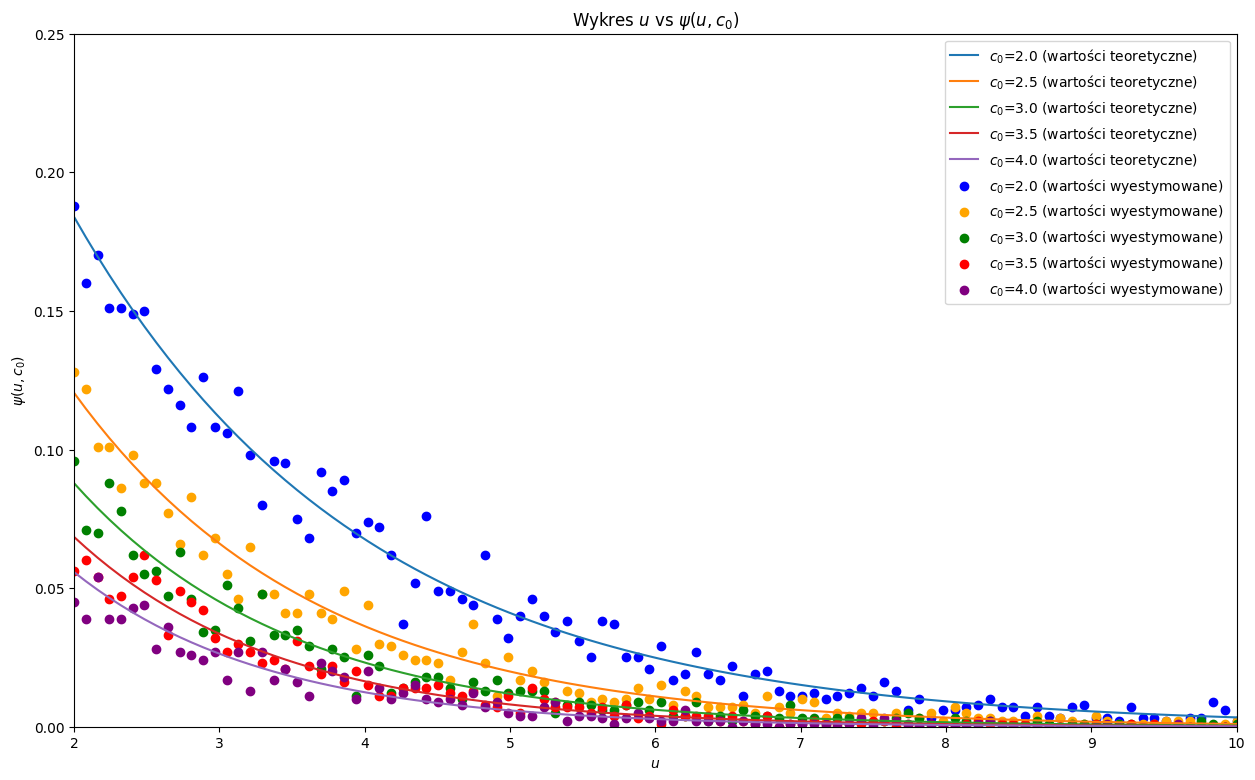

In [33]:
# Inicjalizacja tablic symulacji
sim = np.zeros((10, du))

# Pętla do obliczania ruin_prob_estim dla różnych wartości
for i in range(du):
    for j in range(5):
        sim[j, i] = ruin_prob_estim(eta, us[i], c0s[j], 30, lambd, mc)
    for j in range(5, 10):
        sim[j, i] = ruin_prob_estim(eta, u0s[j - 5], cs[i], 30, lambd, mc)

# Przypisanie wyników do odpowiednich zmiennych
sim1, sim2, sim3, sim4, sim5, sim6, sim7, sim8, sim9, sim10 = sim

plt.figure(figsize=(15, 9))
plt.plot(
    us,
    list(zip(pcs1, pcs2, pcs3, pcs4, pcs5)),
    label=[
        f"$c_0$={c0s[0]} (wartości teoretyczne)",
        f"$c_0$={c0s[1]} (wartości teoretyczne)",
        f"$c_0$={c0s[2]} (wartości teoretyczne)",
        f"$c_0$={c0s[3]} (wartości teoretyczne)",
        f"$c_0$={c0s[4]} (wartości teoretyczne)",
    ],
)
plt.scatter(us, sim1, color="blue", label=f"$c_0$={c0s[0]} (wartości wyestymowane)")
plt.scatter(us, sim2, color="orange", label=f"$c_0$={c0s[1]} (wartości wyestymowane)")
plt.scatter(us, sim3, color="green", label=f"$c_0$={c0s[2]} (wartości wyestymowane)")
plt.scatter(us, sim4, color="red", label=f"$c_0$={c0s[3]} (wartości wyestymowane)")
plt.scatter(us, sim5, color="purple", label=f"$c_0$={c0s[4]} (wartości wyestymowane)")
plt.legend(loc="best")
plt.title("Wykres $u$ vs $\psi (u, c_0)$")
plt.xlabel("$u$")
plt.ylabel("$\psi (u, c_0)$")
ax = plt.gca()
ax.set_xlim([2, 10])
ax.set_ylim([0, 0.25])
plt.show()

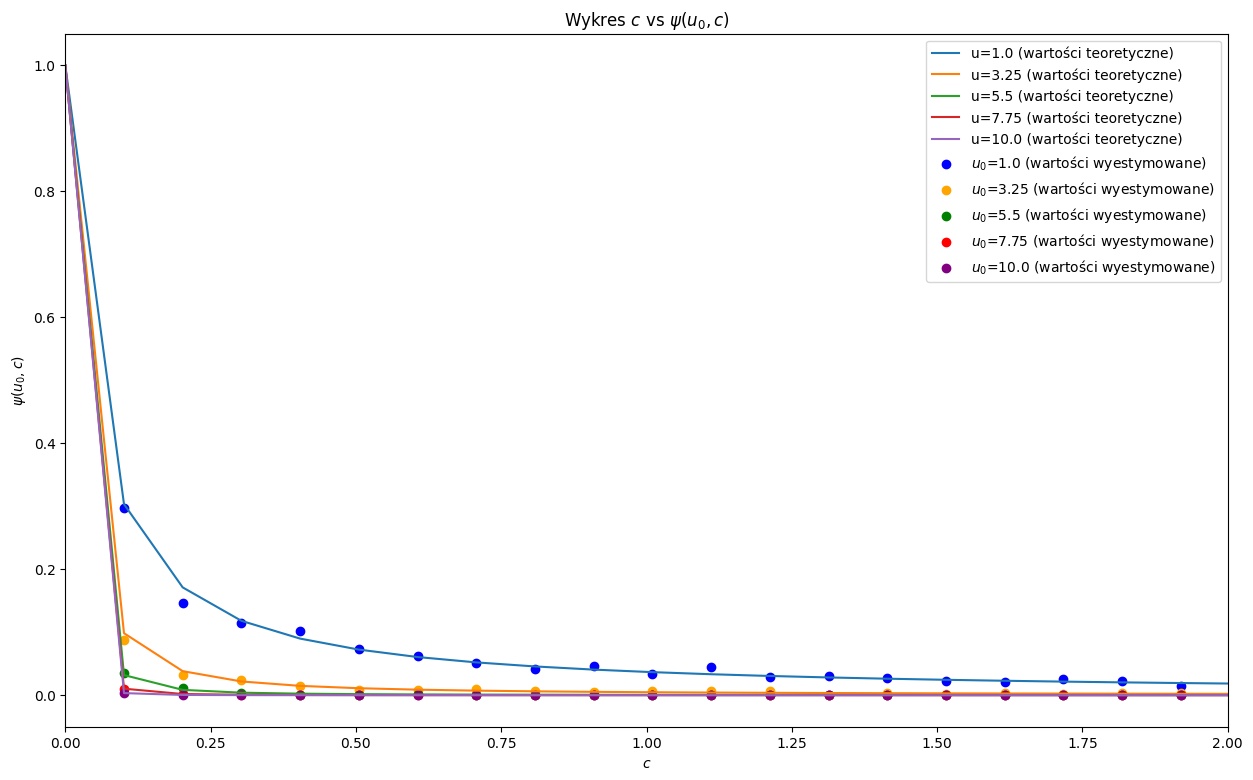

In [32]:
# Generowanie wyników dla każdego elementu w u0s
pcs_list = [pollaczeck_khinchine(u, cs, eta, lambd) for u in u0s]

# Rozpakowanie wyników do zmiennych pcs6, pcs7, pcs8, pcs9, pcs10
pcs6, pcs7, pcs8, pcs9, pcs10 = pcs_list

us2 = np.linspace(0, 10, 100)
plt.figure(figsize=(15, 9))
plt.plot(
    us2,
    list(zip(pcs6, pcs7, pcs8, pcs9, pcs10)),
    label=[
        f"u={u0s[0]} (wartości teoretyczne)",
        f"u={u0s[1]} (wartości teoretyczne)",
        f"u={u0s[2]} (wartości teoretyczne)",
        f"u={u0s[3]} (wartości teoretyczne)",
        f"u={u0s[4]} (wartości teoretyczne)",
    ],
)
plt.scatter(
    us2[1::], sim6[1::], color="blue", label=f"$u_0$={u0s[0]} (wartości wyestymowane)"
)
plt.scatter(
    us2[1::], sim7[1::], color="orange", label=f"$u_0$={u0s[1]} (wartości wyestymowane)"
)
plt.scatter(
    us2[1::], sim8[1::], color="green", label=f"$u_0$={u0s[2]} (wartości wyestymowane)"
)
plt.scatter(
    us2[1::], sim9[1::], color="red", label=f"$u_0$={u0s[3]} (wartości wyestymowane)"
)
plt.scatter(
    us2[1::],
    sim10[1::],
    color="purple",
    label=f"$u_0$={u0s[4]} (wartości wyestymowane)",
)
plt.legend(loc="best")
plt.title("Wykres $c$ vs $\psi (u_0, c)$")
plt.xlabel("$c$")
plt.ylabel("$\psi (u_0, c)$")
ax = plt.gca()
ax.set_xlim([0, 2])
plt.show()

In [13]:
def inv_Poll(u: float, psi: float, lambd: float, eta: float) -> float:
    """
    Implementacja odwróconego wzoru Pollaczka-Khinchina do obliczenia wartości parametru systemowego.

    Odwrócony wzór Pollaczka-Khinchina jest używany do obliczenia wartości parametru systemowego `w`,
    który może być wykorzystany do analizy ryzyka finansowego.

    Parameters:
        u (float): Początkowy kapitał.
            - Musi być dodatni.
        psi (float): Wartość parametru systemowego.
            - Musi być dodatnia.
        lambd (float): Intensywność procesu Poissona (średnia częstość zdarzeń).
            - Musi być dodatnia.
        eta (float): Średnia wartość roszczenia.
            - Musi być dodatnia.

    Returns:
        float: Obliczona wartość parametru systemowego `w`.

    Przykład użycia:
        >>> u = 10
        >>> psi = 0.5
        >>> lambd = 1
        >>> eta = 2
        >>> w = inv_Poll(u, psi, lambd, eta)
        >>> print(w)  # wynik: 2.2582133353406615
    """
    w = scipy.special.lambertw(u * psi * np.exp(u / eta) / eta).real
    return lambd * u / w

In [14]:
# Zakresy i liczba punktów dla parametru psi0
psi0_min = 0.02  # Minimalna wartość parametru psi0
psi0_max = 0.1  # Maksymalna wartość parametru psi0
dpsi0 = 5  # Liczba równo rozmieszczonych punktów między psi0_min a psi0_max
psi0s = np.linspace(psi0_min, psi0_max, dpsi0)  # Tablica wartości parametru psi0

# Generowanie wyników dla każdego elementu w psi0s
cs_list = [inv_Poll(us, psi, lambd, eta) for psi in psi0s]

# Rozpakowanie wyników do zmiennych cs1, cs2, cs3, cs4, cs5
cs1, cs2, cs3, cs4, cs5 = cs_list

In [16]:
def estimation(
    T: float,
    n: int,
    u_vector: np.ndarray,
    c_test: np.ndarray,
    psi: float,
    lambd: float = 1,
    eta: float = 1,
) -> np.ndarray:
    """
    Estymacja wartości parametru składki `c` metodą bisekcji na podstawie zadanego prawdopodobieństwa ruiny kapitału `psi`.

    Funkcja iteracyjnie estymuje wartość parametru składki `c` dla różnych początkowych kapitałów `u` z użyciem
    metody bisekcji, tak aby osiągnąć zadane prawdopodobieństwo ruiny kapitału `psi` w symulacji Monte Carlo.

    Parameters:
        T (float): Czas trwania symulacji.
            - Musi być dodatni.
        n (int): Liczba symulacji Monte Carlo dla każdego przypadku.
            - Musi być dodatnia.
        u_vector (np.ndarray): Tablica zawierająca różne początkowe kapitały `u`, dla których estymowana jest składka `c`.
        c_test (np.ndarray): Tablica zawierająca możliwe wartości parametru składki `c` do przetestowania metodą bisekcji.
        psi (float): Docelowe prawdopodobieństwo ruiny kapitału.
            - Musi być dodatnie.
        lambd (float, optional): Intensywność procesu Poissona (średnia częstość zdarzeń). Domyślnie 1.
            - Musi być dodatnia.
        eta (float, optional): Średnia wartość roszczenia. Domyślnie 1.
            - Musi być dodatnia.

    Returns:
        np.ndarray: Tablica zawierająca oszacowane wartości parametru składki `c` dla każdego początkowego kapitału `u` z `u_vector`.

    Przykład użycia:
        >>> T = 10
        >>> n = 10000
        >>> u_vector = np.array([10, 20, 30])
        >>> c_test = np.linspace(0.1, 2.0, 100)
        >>> psi = 0.1
        >>> estimated_c_values = estimation(T, n, u_vector, c_test, psi)
        >>> print(estimated_c_values)  # wynik: [0.53417969 0.10371094 0.10371094]
    """
    cs = np.zeros(
        len(u_vector)
    )  # Inicjalizacja tablicy na oszacowane wartości parametru składki `c`

    # Iteracja po różnych początkowych kapitałach `u`
    for i, u in enumerate(u_vector):
        c_low, c_high = (
            c_test[0],
            c_test[-1],
        )  # Początkowe wartości dolnej i górnej granicy składki `c`

        # Dopóki różnica między górną i dolną granicą jest większa niż 0.01, wykonuj pętlę
        while c_high - c_low > 0.01:
            c_mid = (c_low + c_high) / 2  # Środkowa wartość składki `c`
            psi_test = ruin_prob_estim(
                eta, u, c_mid, T, lambd, n
            )  # Estymacja prawdopodobieństwa ruiny dla składki `c_mid`

            # Zmniejsz dolną granicę, jeśli oszacowane psi jest większe niż docelowe `psi`
            if psi_test > psi:
                c_low = c_mid
            else:
                c_high = c_mid  # W przeciwnym razie zwiększ górną granicę

        cs[i] = (
            c_low + c_high
        ) / 2  # Ustawienie średniej wartości jako oszacowaną składkę `c` dla kapitału `u`

    return cs  # Zwrócenie tablicy oszacowanych wartości parametru składki `c` dla każdego `u`

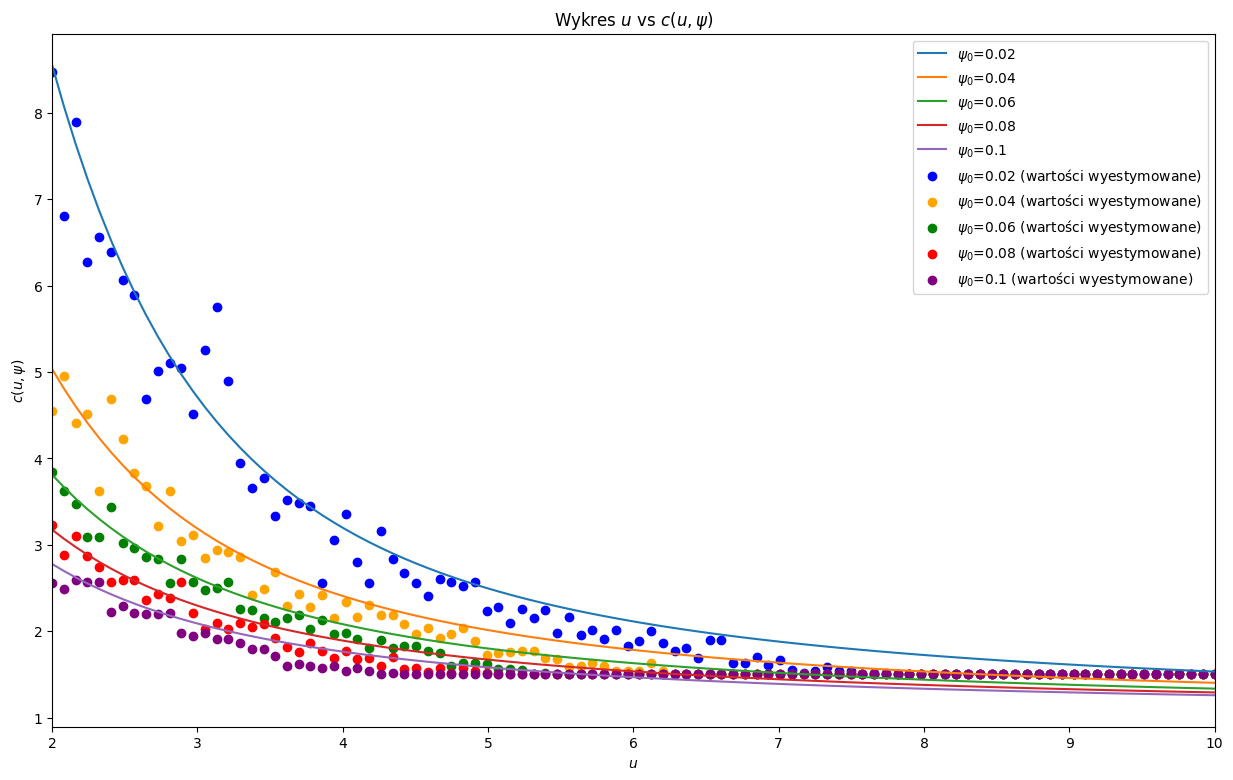

In [18]:
# Definicja parametrów
c_test = np.linspace(1.5, 10, 100)
T = 10

# Estymowanie wartości parametru c dla różnych wartości psi0s
c_empiric_list = [estimation(T, 1000, us, c_test, psi) for psi in psi0s]

# Rozpakowanie wyników do zmiennych c_1_empiric, c_2_empiric, c_3_empiric, c_4_empiric, c_5_empiric
c_1_empiric, c_2_empiric, c_3_empiric, c_4_empiric, c_5_empiric = c_empiric_list

plt.figure(figsize=(15, 9))
plt.plot(
    us,
    list(zip(cs1, cs2, cs3, cs4, cs5)),
    label=[
        f"$\psi_0$={psi0s[0]}",
        f"$\psi_0$={psi0s[1]}",
        f"$\psi_0$={psi0s[2]}",
        f"$\psi_0$={psi0s[3]}",
        f"$\psi_0$={psi0s[4]}",
    ],
)
plt.scatter(
    us, c_1_empiric, color="blue", label=f"$\psi_0$={psi0s[0]} (wartości wyestymowane)"
)
plt.scatter(
    us,
    c_2_empiric,
    color="orange",
    label=f"$\psi_0$={psi0s[1]} (wartości wyestymowane)",
)
plt.scatter(
    us, c_3_empiric, color="green", label=f"$\psi_0$={psi0s[2]} (wartości wyestymowane)"
)
plt.scatter(
    us, c_4_empiric, color="red", label=f"$\psi_0$={psi0s[3]} (wartości wyestymowane)"
)
plt.scatter(
    us,
    c_5_empiric,
    color="purple",
    label=f"$\psi_0$={psi0s[4]} (wartości wyestymowane)",
)
plt.legend(loc="best")
plt.title("Wykres $u$ vs $c(u, \psi)$")
plt.xlabel("$u$")
plt.ylabel("$c(u, \psi)$")
ax = plt.gca()
ax.set_xlim([2, 10])
plt.show()